https://huggingface.co/docs/transformers/en/model_doc/deberta

In [ ]:
!pip install transformers datasets evaluate accelerate peft==0.12.0 patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires py

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import patoolib
import os
import json
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, AutoPeftModelForSequenceClassification
from datasets import Dataset
from torch.utils.data import DataLoader

import evaluate
from tqdm import tqdm

## Fine-tune DEBERTA for sequence classification on 2022 data using PEFT and discourse effectiveness as the target.

In [ ]:
mkdir data2022

In [ ]:
BASIC_PATH = '/content/gdrive/MyDrive/ML/projects/feedback-prize/'

In [ ]:
patoolib.extract_archive(BASIC_PATH+'data/feedback-prize-effectiveness.zip', outdir = '/content/data2022')

INFO patool: Extracting /content/gdrive/MyDrive/ML/projects/feedback-prize/feedback-prize-effectiveness.zip ...
INFO:patool:Extracting /content/gdrive/MyDrive/ML/projects/feedback-prize/feedback-prize-effectiveness.zip ...
INFO patool: running /usr/bin/7z x -o/content/data2022 -- /content/gdrive/MyDrive/ML/projects/feedback-prize/feedback-prize-effectiveness.zip
INFO:patool:running /usr/bin/7z x -o/content/data2022 -- /content/gdrive/MyDrive/ML/projects/feedback-prize/feedback-prize-effectiveness.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/gdrive/MyDrive/ML/projects/feedback-prize/feedback-prize-effectiveness.zip extracted to `/content/data2022'.
INFO:patool:... /content/gdrive/MyDrive/ML/projects/feedback-prize/feedback-prize-effectiveness.zip extracted to `/content/data2022'.


'/content/data2022'

In [ ]:
input_dir = '/content/data2022'

train_csv = os.path.join(input_dir, 'train.csv')

data_2022 = pd.read_csv(train_csv)

We will load the train_ids from the splits created in the EDA notebook. The train_ids represent the portion of the dataset used for training the first-level models.

In [ ]:
with open(BASIC_PATH+'data_splits.json', 'r') as file:
    loaded_essay_ids = json.load(file)

In [ ]:
train_ids = loaded_essay_ids['train_ids']
train_2022 = data_2022[data_2022['essay_id'].isin(train_ids)].copy()

In [ ]:
train_2022['essay_id'].nunique()

2681

In [ ]:
train_2022.reset_index(drop = True, inplace = True)

We will now create a separate text column to be used as a predictor, combining the discourse type with the discourse text itself.

In [ ]:
train_2022['text'] = train_2022['discourse_type'] + ' ' + train_2022['discourse_text']

In [ ]:
train_2022.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text
0,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,Lead Limiting the usage of cars has personal a...
1,de347c859ab6,00944C693682,With so many things in this world that few peo...,Position,Effective,Position With so many things in this world tha...
2,cc921c5cfda4,00944C693682,stress.,Claim,Adequate,Claim stress.
3,a6fcdd9110ab,00944C693682,It is no secret that morning traffic jams and ...,Evidence,Effective,Evidence It is no secret that morning traffic ...
4,6efd9102298b,00944C693682,the environment suffers greatly from the many ...,Claim,Effective,Claim the environment suffers greatly from the...


The discourse effectiveness will be used as target.

In [ ]:
train_2022['discourse_effectiveness'].value_counts()

,count
discourse_effectiveness,
Adequate,13399
Effective,5904
Ineffective,4159


In [ ]:
train_2022['text_len'] = train_2022['text'].apply(lambda x: len(x.split(' ')))

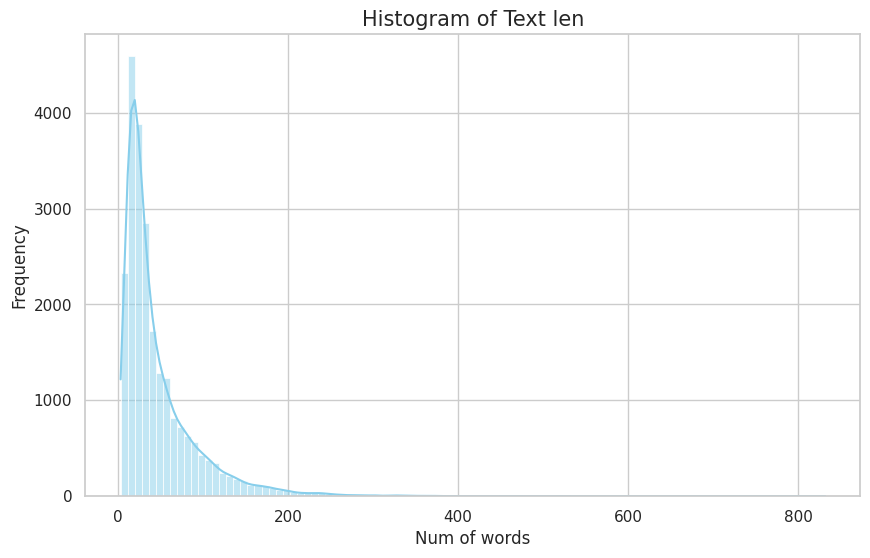

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize = (10, 6))
sns.histplot(train_2022['text_len'], bins = 100, kde = True, color = 'skyblue')

plt.title('Histogram of Text len', fontsize = 15)
plt.xlabel('Num of words', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

### Preprocessing

In [ ]:
dataset = Dataset.from_pandas(train_2022[['text',	'discourse_effectiveness']])

In [ ]:
dataset

Dataset({
    features: ['text', 'discourse_effectiveness'],
    num_rows: 23462
})

In [ ]:
BASE_MODEL = 'microsoft/deberta-v3-base'
TRAINED_TOKENIZER = 'deberta-base-tokenizer'
PEFT_MODEL = 'deberta-base-peft-2022'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, clean_up_tokenization_spaces = True, use_fast = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
def preprocess(data):
    tokenized = tokenizer(data['text'], max_length = 200, truncation = True, padding = 'max_length')
    return tokenized

In [ ]:
tokenized_dataset = dataset.map(preprocess, batched = True, remove_columns = ['text'])

Map:   0%|          | 0/23462 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['discourse_effectiveness', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 23462
})

In [ ]:
class_names = list(set(train_2022['discourse_effectiveness']))
class_names.sort()

In [ ]:
label_to_id = {label: i for i, label in enumerate(class_names)}
id_to_label = {i: label for i, label in enumerate(class_names)}

In [ ]:
id_to_label

{0: 'Adequate', 1: 'Effective', 2: 'Ineffective'}

In [ ]:
def encode_labels(data):
    data['label'] = label_to_id[data['discourse_effectiveness']]
    return data

In [ ]:
tokenized_dataset = tokenized_dataset.map(encode_labels, remove_columns = ['discourse_effectiveness'])

Map:   0%|          | 0/23462 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 23462
})

We will now split the dataset into training and validation sets to control for overfitting.

In [ ]:
tokenized_dataset = tokenized_dataset.shuffle(seed = 89)

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size = 0.2, seed = 98)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 18769
})

In [ ]:
Counter(train_dataset['label'])

Counter({2: 3339, 0: 10719, 1: 4711})

### Train DEBERTA model with LORA using PEFT library

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'pt')

In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 2,
)

In [ ]:
training_args = TrainingArguments(
    output_dir = './peft-2022',
    eval_strategy = 'steps',
    eval_steps = 500,
    learning_rate = 0.0001,
    num_train_epochs = 10,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
)

# Function to get the Trainer
def get_trainer(model):
    return Trainer(
        model = model,
        args = training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        data_collator = data_collator,
        callbacks = [early_stopping_callback]
    )

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels = len(class_names), id2label = id_to_label, label2id = label_to_id)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
peft_config = LoraConfig(task_type = "SEQ_CLS",
                         inference_mode = False,
                         target_modules = 'all-linear',
                         r = 8,
                         lora_alpha = 16,
                         lora_dropout = 0.2)

peft_model = get_peft_model(model, peft_config)

In [ ]:
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DebertaV2ForSequenceClassification(
      (deberta): DebertaV2Model(
        (embeddings): DebertaV2Embeddings(
          (word_embeddings): Embedding(128100, 768, padding_idx=0)
          (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
          (dropout): StableDropout()
        )
        (encoder): DebertaV2Encoder(
          (layer): ModuleList(
            (0-11): 12 x DebertaV2Layer(
              (attention): DebertaV2Attention(
                (self): DisentangledSelfAttention(
                  (query_proj): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )


In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 1,347,867 || all params: 185,778,486 || trainable%: 0.7255


In [ ]:
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

base_model.model.deberta.encoder.layer.0.attention.self.query_proj.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.self.query_proj.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.attention.self.key_proj.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.self.key_proj.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.attention.self.value_proj.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.self.value_proj.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.attention.output.dense.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.output.dense.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.intermediate.dense.lora_A.default.weight: torch.Size([8, 768])
base_model.model.d

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_counts = Counter(train_dataset['label'])
class_weights = torch.tensor([len(train_dataset) / label_counts[i] for i in range(len(class_names))]).to(device)

loss_fn = nn.CrossEntropyLoss(weight = class_weights)

def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss = loss_fn(logits, labels)

    if return_outputs:
        return loss, outputs
    return loss

In [ ]:
class_weights

tensor([1.7510, 3.9841, 5.6211], device='cuda:0')

In [ ]:
peft_trainer = get_trainer(peft_model)
peft_trainer.compute_loss = compute_loss

In [ ]:
peft_trainer.compute_loss

<function __main__.compute_loss(model, inputs, return_outputs=False)>

In [ ]:
peft_trainer.train()

Step,Training Loss,Validation Loss
500,0.899800,0.861818
1000,0.780100,0.772960
1500,0.748800,0.773517
2000,0.694300,0.780949


TrainOutput(global_step=2000, training_loss=0.7807526092529297, metrics={'train_runtime': 2654.7511, 'train_samples_per_second': 70.7, 'train_steps_per_second': 2.211, 'total_flos': 6677245054620000.0, 'train_loss': 0.7807526092529297, 'epoch': 3.4071550255536627})

Run inference on the validation data to verify that the model has been trained to a reasonable extent.

In [ ]:
# Initialize evaluation metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

def evaluate_model(inference_model, dataset):

    # Set the model to evaluation mode
    inference_model.eval()

    # Move the model to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inference_model.to(device)

    test_dataloader = DataLoader(dataset, batch_size=4, collate_fn=data_collator)

    # Iterate over the test data
    for batch in tqdm(test_dataloader):
        # Move batch to the appropriate device
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = inference_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        predictions = outputs.logits.argmax(dim=-1)
        references = batch['labels']

        # Add batch to the metrics
        accuracy_metric.add_batch(predictions=predictions, references=references)
        f1_metric.add_batch(predictions=predictions, references=references)
        precision_metric.add_batch(predictions=predictions, references=references)
        recall_metric.add_batch(predictions=predictions, references=references)

    # Compute and print the metrics
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average='weighted')
    precision = precision_metric.compute(average='weighted')
    recall = recall_metric.compute(average='weighted')

    print(f"Accuracy: {accuracy['accuracy']}")
    print(f"F1 Score: {f1['f1']}")
    print(f"Precision: {precision['precision']}")
    print(f"Recall: {recall['recall']}")

In [ ]:
evaluate_model(peft_model, eval_dataset)

100%|██████████| 1174/1174 [01:34<00:00, 12.36it/s]

Accuracy: 0.6019603665033028
F1 Score: 0.6045499853765574
Precision: 0.6301845143143179
Recall: 0.6019603665033026


In [ ]:
def predict_labels(inference_model, dataset):

    # Set the model to evaluation mode
    inference_model.eval()

    # Move the model to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inference_model.to(device)

    test_dataloader = DataLoader(dataset, batch_size = 8, collate_fn = data_collator, shuffle = False)

    predictions_list = []

    # Iterate over the test data
    for batch in tqdm(test_dataloader):

        # Move batch to the appropriate device
        batch = {k: v.to(device) for k, v in batch.items()}  # Skip 'labels' key

        with torch.no_grad():
            outputs = inference_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Get predictions
        predictions = outputs.logits.argmax(dim=-1)
        predictions_list.extend(predictions.cpu().numpy())  # Convert to CPU and store predictions

    return predictions_list

In [ ]:
test_preds = predict_labels(peft_model, eval_dataset)

100%|██████████| 587/587 [01:21<00:00,  7.22it/s]


In [ ]:
Counter(eval_dataset['label'])

Counter({0: 2680, 2: 820, 1: 1193})

In [ ]:
Counter(test_preds)

Counter({2: 1098, 1: 1559, 0: 2036})

In [ ]:
# tokenizer.save_pretrained(BASIC_PATH + TRAINED_TOKENIZER)
# torch.save(peft_model.state_dict(), BASIC_PATH + 'deberta_base_peft_2022_weights.pth')

## Sanity check that the model has been saved correctly

In [ ]:
TOKENIZER_PATH = BASIC_PATH + TRAINED_TOKENIZER
DEBERTA_WEIGHTS = BASIC_PATH + 'deberta_base_peft_2022_weights.pth'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, clean_up_tokenization_spaces = True, use_fast = False)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels = len(class_names), id2label = id_to_label, label2id = label_to_id)

peft_config = LoraConfig(task_type = "SEQ_CLS",
                         inference_mode = False,
                         target_modules = 'all-linear',
                         r = 8,
                         lora_alpha = 16,
                         lora_dropout = 0.2)

inference_model = get_peft_model(model, peft_config)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inference_model.load_state_dict(torch.load(DEBERTA_WEIGHTS))

<ipython-input-68-ad03277b5b65>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_model.load_state_dict(torch.load(DEBERTA_WEIGHTS))


<All keys matched successfully>

In [ ]:
evaluate_model(inference_model, eval_dataset)

100%|██████████| 1174/1174 [01:32<00:00, 12.74it/s]


Accuracy: 0.6019603665033028
F1 Score: 0.6045499853765574
Precision: 0.6301845143143179
Recall: 0.6019603665033026


In [ ]:
# WARNING: DO NOT USE THE BELOW APPROACH TO SAVE AND LOAD YOUR TRAINED DEBERTA PEFT MODEL
# BECAUSE THE FOLLOWING LAYERS WILL STILL BE RE-INITIALIZED:
# 'classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight'
# WHICH WOULD RESULT IN POOR QUALITY

# peft_model.save_pretrained(BASIC_PATH + PEFT_MODEL)

# PEFT_MODEL_PATH = BASIC_PATH + PEFT_MODEL

# inference_model = AutoPeftModelForSequenceClassification.from_pretrained(PEFT_MODEL_PATH, id2label = id_to_label, label2id = label_to_id)


# TO AVOID THIS PROBLEM, CONSIDER USING CUSTOM SAVER:

# class CustomSaveWrapper(nn.Module):
#     def __init__(self, module):
#         super().__init__()
#         self.module = module
#         self.saved_weights = {}

#     def forward(self, *args, **kwargs):
#         return self.module(*args, **kwargs)

#     def save_weights(self):
#         self.saved_weights['weight'] = self.module.weight.data.clone()
#         if self.module.bias is not None:
#             self.saved_weights['bias'] = self.module.bias.data.clone()

#     def load_weights(self):
#         self.module.weight.data = self.saved_weights['weight'].clone()
#         if 'bias' in self.saved_weights:
#             self.module.bias.data = self.saved_weights['bias'].clone()

# peft_model.pooler.dense = CustomSaveWrapper(peft_model.pooler.dense)

In [ ]:
# test pre-trained DEBERTA for comparison

base_inference_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label = id_to_label, label2id = label_to_id)

evaluate_model(base_inference_model, eval_dataset)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1174/1174 [01:25<00:00, 13.77it/s]

Accuracy: 0.2542083954826337
F1 Score: 0.10304811954155013
Precision: 0.0646219083338551
Recall: 0.2542083954826337



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Run inference on the 2021 data to generate pseudo-labels.

In [ ]:
TOKENIZER_PATH = BASIC_PATH + TRAINED_TOKENIZER
DEBERTA_WEIGHTS = BASIC_PATH + 'deberta_base_peft_2022_weights.pth'

In [ ]:
class_names = list(set(train_2022['discourse_effectiveness']))
class_names.sort()

label_to_id = {label: i for i, label in enumerate(class_names)}
id_to_label = {i: label for i, label in enumerate(class_names)}

In [ ]:
label_to_id

{'Adequate': 0, 'Effective': 1, 'Ineffective': 2}

In [ ]:
data_2021 = pd.read_csv(BASIC_PATH + 'data/train_2021.csv')

In [ ]:
data_2021['text'] = data_2021['discourse_type'] + ' ' + data_2021['discourse_text']

In [ ]:
dataset_2021 = Dataset.from_pandas(data_2021[['text']])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, clean_up_tokenization_spaces = True, use_fast = False)

In [ ]:
tokenized_dataset_2021 = dataset_2021.map(preprocess, batched = True, remove_columns = ['text'])

Map:   0%|          | 0/144293 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'pt')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels = len(class_names), id2label = id_to_label, label2id = label_to_id)

peft_config = LoraConfig(task_type = "SEQ_CLS",
                         inference_mode = True,
                         target_modules = 'all-linear',
                         r = 8,
                         lora_alpha = 16,
                         lora_dropout = 0.2)

inference_model = get_peft_model(model, peft_config)

inference_model.load_state_dict(torch.load(DEBERTA_WEIGHTS))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-118-151465eb3eb0>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

<All keys matched successfully>

In [ ]:
predicted_labels = predict_labels(inference_model, tokenized_dataset_2021)

100%|██████████| 18037/18037 [41:19<00:00,  7.28it/s]


In [ ]:
data_2021['predictions'] = predicted_labels

In [ ]:
data_2021['predictions'].value_counts()

,count
predictions,
0,63172
1,58088
2,23033


In [ ]:
#data_2021.to_csv(BASIC_PATH+'data/data_2021_with_pseudo_labels.csv', index = False)

## Fine-tune the model on the 2021 pseudo-labelled data

In [ ]:
BASIC_PATH = '/content/gdrive/MyDrive/ML/projects/feedback-prize/'

data_2021 = pd.read_csv(BASIC_PATH+'data/data_2021_with_pseudo_labels.csv')

In [ ]:
data_2021.rename(columns = {"predictions": "label"}, inplace = True)

In [ ]:
data_2021.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,text,label
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,Lead Modern humans today are always on their p...,0
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,Position They are some really bad consequences...,2
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,Evidence Some certain areas in the United Stat...,2
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,"Evidence When people have phones, they know ab...",2
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,Claim Driving is one of the way how to get aro...,0


In [ ]:
class_names = list(set(train_2022['discourse_effectiveness']))
class_names.sort()

label_to_id = {label: i for i, label in enumerate(class_names)}
id_to_label = {i: label for i, label in enumerate(class_names)}

In [ ]:
id_to_label

{0: 'Adequate', 1: 'Effective', 2: 'Ineffective'}

In [ ]:
dataset = Dataset.from_pandas(data_2021[['text', 'label']])

In [ ]:
tokenized_dataset_2021 = dataset.map(preprocess, batched = True, remove_columns = ['text'])

Map:   0%|          | 0/144293 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_2021

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 144293
})

In [ ]:
tokenized_dataset_2021 = tokenized_dataset_2021.shuffle(seed = 89)

train_test_split = tokenized_dataset_2021.train_test_split(test_size = 0.2, seed = 77)
train_dataset_2021 = train_test_split['train']
eval_dataset_2021 = train_test_split['test']

In [ ]:
TOKENIZER_PATH = BASIC_PATH + TRAINED_TOKENIZER
DEBERTA_WEIGHTS = BASIC_PATH + 'deberta_base_peft_2022_weights.pth'

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, clean_up_tokenization_spaces = True, use_fast = False)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels = len(class_names), id2label = id_to_label, label2id = label_to_id)

peft_config = LoraConfig(task_type = "SEQ_CLS",
                         inference_mode = False,
                         target_modules = 'all-linear',
                         r = 8,
                         lora_alpha = 16,
                         lora_dropout = 0.2)

model_2022 = get_peft_model(model, peft_config)
model_2022.load_state_dict(torch.load(DEBERTA_WEIGHTS))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-134-3e043b31fffa>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

<All keys matched successfully>

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'pt')

In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 2,
)

In [ ]:
training_args = TrainingArguments(
    output_dir = './peft-2021',
    eval_strategy = 'steps',
    eval_steps = 500,
    learning_rate = 5e-5,
    num_train_epochs = 10,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
)

# Function to get the Trainer
def get_trainer(model):
    return Trainer(
        model = model,
        args = training_args,
        train_dataset = train_dataset_2021,
        eval_dataset = eval_dataset_2021,
        data_collator = data_collator,
        callbacks = [early_stopping_callback]
    )

In [ ]:
for name, param in model_2022.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

base_model.model.deberta.encoder.layer.0.attention.self.query_proj.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.self.query_proj.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.attention.self.key_proj.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.self.key_proj.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.attention.self.value_proj.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.self.value_proj.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.attention.output.dense.lora_A.default.weight: torch.Size([8, 768])
base_model.model.deberta.encoder.layer.0.attention.output.dense.lora_B.default.weight: torch.Size([768, 8])
base_model.model.deberta.encoder.layer.0.intermediate.dense.lora_A.default.weight: torch.Size([8, 768])
base_model.model.d

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_counts = Counter(train_dataset_2021['label'])
class_weights = torch.tensor([len(train_dataset_2021) / label_counts[i] for i in range(len(class_names))]).to(device)

loss_fn = nn.CrossEntropyLoss(weight = class_weights)

def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss = loss_fn(logits, labels)

    if return_outputs:
        return loss, outputs
    return loss

In [ ]:
class_weights

tensor([2.2819, 2.4843, 6.2801], device='cuda:0')

In [ ]:
model_trainer = get_trainer(model_2022)
model_trainer.compute_loss = compute_loss

In [ ]:
model_trainer.train()

Step,Training Loss,Validation Loss
500,0.283400,0.194048
1000,0.237100,0.198773
1500,0.223700,0.240718


TrainOutput(global_step=1500, training_loss=0.24806621805826823, metrics={'train_runtime': 2336.9641, 'train_samples_per_second': 493.949, 'train_steps_per_second': 30.873, 'total_flos': 2505728736000000.0, 'train_loss': 0.24806621805826823, 'epoch': 0.2079002079002079})

In [ ]:
evaluate_model(model_2022, eval_dataset_2021)

100%|██████████| 7215/7215 [09:47<00:00, 12.29it/s]


Accuracy: 0.9189161093592987
F1 Score: 0.9181746857178866
Precision: 0.9222224453543703
Recall: 0.9189161093592987


## Fine-tune the last layers of the trained model on the 2022 data.

In [ ]:
dataset = Dataset.from_pandas(train_2022[['text',	'discourse_effectiveness']])

In [ ]:
dataset

Dataset({
    features: ['text', 'discourse_effectiveness'],
    num_rows: 23462
})

In [ ]:
TOKENIZER_PATH = BASIC_PATH + TRAINED_TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, clean_up_tokenization_spaces = True, use_fast = False)

In [ ]:
tokenized_dataset_2022 = dataset.map(preprocess, batched = True, remove_columns = ['text'])

Map:   0%|          | 0/23462 [00:00<?, ? examples/s]

In [ ]:
class_names = list(set(train_2022['discourse_effectiveness']))
class_names.sort()

In [ ]:
label_to_id = {label: i for i, label in enumerate(class_names)}
id_to_label = {i: label for i, label in enumerate(class_names)}

In [ ]:
id_to_label

{0: 'Adequate', 1: 'Effective', 2: 'Ineffective'}

In [ ]:
tokenized_dataset_2022 = tokenized_dataset_2022.map(encode_labels, remove_columns = ['discourse_effectiveness'])

Map:   0%|          | 0/23462 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_2022

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 23462
})

We will now split the dataset into training and validation sets to control for overfitting.

In [ ]:
tokenized_dataset_2022 = tokenized_dataset_2022.shuffle(seed = 79)

In [ ]:
train_test_split = tokenized_dataset_2022.train_test_split(test_size = 0.2, seed = 88)
train_dataset_2022 = train_test_split['train']
eval_dataset_2022 = train_test_split['test']

In [ ]:
train_dataset_2022

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 18769
})

In [ ]:
Counter(train_dataset_2022['label'])

Counter({1: 4746, 0: 10713, 2: 3310})

In [ ]:
evaluate_model(model_2022, eval_dataset_2022)

100%|██████████| 1174/1174 [02:03<00:00,  9.52it/s]


Accuracy: 0.6013211165565736
F1 Score: 0.6002178808961465
Precision: 0.6405945691696497
Recall: 0.6013211165565736


In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 2,
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'pt')

In [ ]:
training_args = TrainingArguments(
    output_dir = './ft-2022',
    eval_strategy = 'steps',
    eval_steps = 500,
    learning_rate = 5e-5,
    num_train_epochs = 10,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
)

# Function to get the Trainer
def get_trainer(model):
    return Trainer(
        model = model,
        args = training_args,
        train_dataset = train_dataset_2022,
        eval_dataset = eval_dataset_2022,
        data_collator = data_collator,
        callbacks = [early_stopping_callback]
    )

In [ ]:
for name, param in model_2022.named_parameters():
    if 'pooler' not in name and 'classifier' not in name:
        param.requires_grad = False

In [ ]:
for name, param in model_2022.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

base_model.model.pooler.dense.lora_A.default.weight: torch.Size([8, 768])
base_model.model.pooler.dense.lora_B.default.weight: torch.Size([768, 8])
base_model.model.classifier.modules_to_save.default.base_layer.weight: torch.Size([3, 768])
base_model.model.classifier.modules_to_save.default.base_layer.bias: torch.Size([3])
base_model.model.classifier.modules_to_save.default.lora_A.default.weight: torch.Size([8, 768])
base_model.model.classifier.modules_to_save.default.lora_B.default.weight: torch.Size([3, 8])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_counts = Counter(train_dataset_2022['label'])
class_weights = torch.tensor([len(train_dataset_2022) / label_counts[i] for i in range(len(class_names))]).to(device)

loss_fn = nn.CrossEntropyLoss(weight = class_weights)

def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss = loss_fn(logits, labels)

    if return_outputs:
        return loss, outputs
    return loss

In [ ]:
class_weights

tensor([1.7520, 3.9547, 5.6704], device='cuda:0')

In [ ]:
model_trainer = get_trainer(model_2022)
model_trainer.compute_loss = compute_loss

In [ ]:
model_trainer.train()

Step,Training Loss,Validation Loss
500,0.886700,0.777552
1000,0.769900,0.761173
1500,0.741600,0.761240
2000,0.757000,0.756206
2500,0.749400,0.758621
3000,0.751700,0.758727


TrainOutput(global_step=3000, training_loss=0.7760317586263021, metrics={'train_runtime': 1440.2987, 'train_samples_per_second': 130.313, 'train_steps_per_second': 8.151, 'total_flos': 5008325311080000.0, 'train_loss': 0.7760317586263021, 'epoch': 2.555366269165247})

In [ ]:
evaluate_model(model_2022, eval_dataset_2022)

100%|██████████| 1174/1174 [01:35<00:00, 12.30it/s]


Accuracy: 0.6111229490730876
F1 Score: 0.6116544110404852
Precision: 0.6475665414492908
Recall: 0.6111229490730876


In [ ]:
#torch.save(model_2022.state_dict(), BASIC_PATH + '1st_level_models/deberta_trained_2022_weights.pth')

Sanity check that the final model has been saved correctly.

In [ ]:
TOKENIZER_PATH = BASIC_PATH + TRAINED_TOKENIZER
FINAL_WEIGHTS = BASIC_PATH + '1st_level_models/deberta_trained_2022_weights.pth'

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, clean_up_tokenization_spaces = True, use_fast = False)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels = len(class_names), id2label = id_to_label, label2id = label_to_id)

peft_config = LoraConfig(task_type = "SEQ_CLS",
                         inference_mode = True,
                         target_modules = 'all-linear',
                         r = 8,
                         lora_alpha = 16,
                         lora_dropout = 0.2)

final_model = get_peft_model(model, peft_config)
final_model.load_state_dict(torch.load(FINAL_WEIGHTS))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-177-bd8b88ea4f65>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

<All keys matched successfully>

In [ ]:
# Another sanity check
evaluate_model(final_model, eval_dataset_2022)

100%|██████████| 1174/1174 [01:38<00:00, 11.91it/s]


Accuracy: 0.6111229490730876
F1 Score: 0.6116544110404852
Precision: 0.6475665414492908
Recall: 0.6111229490730876
